<a href="https://colab.research.google.com/github/thisisindrajit/Athena/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Athena - Portfolio Optimization using Machine Learning

Athena uses a novel approach to portfolio optimization. It combines both deep learning and statistics along with asset fundamentals analysis to generate a robust portfolio with maximal returns and minimal risk. 

## Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [1]:
!pip install yfinance

import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential, load_model
# from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K
import scipy
import pandas as pd
# from pandas_datareader import data as pdr
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

print(tf.__version__)
print("All neccessary imports done!")

2.8.0
All neccessary imports done!


## Variables

**Sample Portfolio 1**

1. Asian Paints - ASIANPAINT.NS
1. Reliance - RELIANCE.NS
1. Pidilite Industries - PIDILITIND.NS
1. Lupin - LUPIN.NS
1. Indian Oil Corporation - IOC.NS

tickers = ["ASIANPAINT.NS", "RELIANCE.NS", "PIDILITIND.NS", "LUPIN.NS", "IOC.NS"]

---

**Sample Portfolio 2**

1. Adani Ports - ADANIPORTS.NS
1. Asian Paints - ASIANPAINT.NS
1. Axis Bank - AXISBANK.NS
1. ICICI - ICICIBANK.NS
1. Cipla - CIPLA.NS
1. Infosys -  INFY.NS
1. Lupin - LUPIN.NS
1. Dr Reddys Labs - DRREDDY.NS
1. Coal India - COALINDIA.NS
1. Airtel - BHARTIARTL.NS
1. Deepak Nitrite - DEEPAKNTR.NS
1. Expleo Solutions - EXPLEOSOL.NS

tickers = ["ADANIPORTS.NS", "ASIANPAINT.NS", "AXISBANK.NS", "ICICIBANK.NS", "CIPLA.NS", "INFY.NS", "LUPIN.NS", "DRREDDY.NS", "COALINDIA.NS", "BHARTIARTL.NS", "DEEPAKNTR.NS", "EXPLEOSOL.NS"]

In [2]:
tickers = ["ADANIPORTS.NS", "ASIANPAINT.NS", "AXISBANK.NS", "ICICIBANK.NS", "CIPLA.NS", 
           "INFY.NS", "LUPIN.NS", "DRREDDY.NS", "COALINDIA.NS", "BHARTIARTL.NS", "DEEPAKNTR.NS", 
           "EXPLEOSOL.NS"]
# sorting tickers
tickers.sort()

time_steps = 100
features = 1
port_len = len(tickers)

## Getting data from API

In [3]:
def get_data(tickers, getInfo=True, period="5y"):
  
  # download data of ticker symbol
  data = yf.download(tickers, period=period)
  
  if(getInfo):
    info = []

    for ticker in tickers: 
      info.append(yf.Ticker(ticker).info)
  
  # remove open, high, low, volume, adj close columns
  data = data.drop("Open", axis = 1)
  data = data.drop("High", axis = 1)
  data = data.drop("Low", axis = 1)
  data = data.drop("Volume", axis = 1)
  data = data.drop("Adj Close", axis = 1)

  if getInfo:
    return data, info
  else:
    return data

In [4]:
# valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max

# df, info = get_data(tickers)
df = get_data(tickers, getInfo=False, period="5y")

[*********************100%***********************]  12 of 12 completed


In [5]:
df = df["Close"]
df

,ADANIPORTS.NS,ASIANPAINT.NS,AXISBANK.NS,BHARTIARTL.NS,CIPLA.NS,COALINDIA.NS,DEEPAKNTR.NS,DRREDDY.NS,EXPLEOSOL.NS,ICICIBANK.NS,INFY.NS,LUPIN.NS
Date,,,,,,,,,,,,
2017-03-24,323.250000,1064.250000,489.350006,312.639740,593.950012,297.850006,122.099998,2628.350098,551.750000,249.772720,515.700012,1487.800049
2017-03-27,319.299988,1042.900024,487.149994,310.987000,592.099976,291.500000,121.449997,2631.949951,551.750000,248.318176,514.424988,1457.750000
2017-03-28,320.850006,1057.849976,502.799988,312.869293,594.150024,290.350006,120.500000,2637.750000,547.650024,251.818176,517.575012,1455.699951
2017-03-29,321.000000,1068.099976,504.200012,316.633820,593.150024,294.100006,121.849998,2633.649902,548.500000,256.545441,515.924988,1454.349976
2017-03-30,339.299988,1070.099976,499.250000,322.464233,598.349976,289.500000,123.300003,2613.250000,550.200012,255.772720,512.750000,1446.949951
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-17,740.099976,3136.600098,739.250000,722.900024,1048.500000,176.550003,2228.899902,4042.149902,1485.449951,720.099976,1854.599976,765.349976
2022-03-21,735.150024,3045.750000,725.900024,708.200012,1050.300049,182.300003,2269.800049,4004.949951,1482.000000,710.750000,1853.050049,755.150024
2022-03-22,739.150024,3051.149902,731.400024,719.250000,1032.599976,183.350006,2255.449951,4030.350098,1459.050049,718.200012,1887.400024,757.250000


## Converting company info to DataFrame

In [ ]:
# Information of the company of first ticker symbol
infodf0 = pd.DataFrame.from_dict(info[0],orient='index')
infodf0 = infodf0.reset_index()
infodf0

,index,0
0,zip,400055
1,sector,Basic Materials
2,fullTimeEmployees,7134
3,longBusinessSummary,"Asian Paints Limited, together with its subsid..."
4,city,Mumbai
...,...,...
148,bidSize,0
149,dayHigh,3079.9
150,regularMarketPrice,3016.8
151,preMarketPrice,None


## Visualizing the data

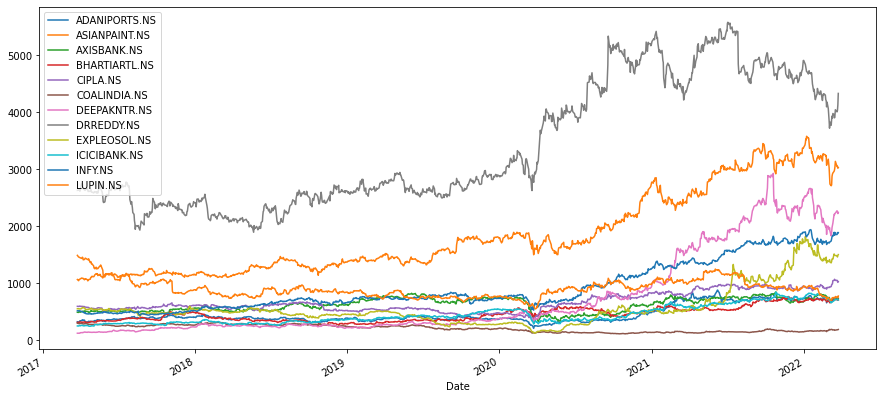

In [6]:
# Pandas has inbuilt support for matplotlib, so we can use plot function directly

df.plot(label = tickers, figsize = (15,7))

# Deep Learning model for future price prediction

## Preprocessing

In [ ]:
# shifting is done here to ensure that the next day's price is predicted on the given day
df_shift = df.shift(-1)

label = df_shift

print(label)

            ASIANPAINT.NS      IOC.NS     LUPIN.NS  PIDILITIND.NS  RELIANCE.NS
Date                                                                          
2017-03-23    1064.250000  186.350006  1487.800049     688.250000   637.333740
2017-03-24    1042.900024  185.449997  1457.750000     682.900024   619.676086
2017-03-27    1057.849976  184.524994  1455.699951     696.500000   617.026184
2017-03-28    1068.099976  185.074997  1454.349976     689.099976   622.425049
2017-03-29    1070.099976  188.399994  1446.949951     690.950012   629.359314
...                   ...         ...          ...            ...          ...
2022-03-16    3136.600098  121.349998   765.349976    2510.399902  2481.699951
2022-03-17    3045.750000  118.000000   755.150024    2485.250000  2467.399902
2022-03-21    3051.149902  120.650002   757.250000    2450.350098  2531.149902
2022-03-22    3007.300049  121.199997   752.500000    2421.899902  2542.000000
2022-03-23            NaN         NaN          NaN  

In [ ]:
# adjusting the shape of both df and label (since label contains NaN as the last value)

df.drop(df.index[len(df)-1], axis=0, inplace=True)
label.drop(label.index[len(label)-1], axis=0, inplace=True)

In [ ]:
df

,ASIANPAINT.NS,IOC.NS,LUPIN.NS,PIDILITIND.NS,RELIANCE.NS
Date,,,,,
2017-03-23,1061.599976,188.399994,1490.250000,693.849976,630.671875
2017-03-24,1064.250000,186.350006,1487.800049,688.250000,637.333740
2017-03-27,1042.900024,185.449997,1457.750000,682.900024,619.676086
2017-03-28,1057.849976,184.524994,1455.699951,696.500000,617.026184
2017-03-29,1068.099976,185.074997,1454.349976,689.099976,622.425049
...,...,...,...,...,...
2022-03-15,2987.149902,119.000000,737.950012,2370.550049,2363.449951
2022-03-16,3042.000000,121.949997,749.599976,2462.899902,2403.350098
2022-03-17,3136.600098,121.349998,765.349976,2510.399902,2481.699951


In [ ]:
label

,ASIANPAINT.NS,IOC.NS,LUPIN.NS,PIDILITIND.NS,RELIANCE.NS
Date,,,,,
2017-03-23,1064.250000,186.350006,1487.800049,688.250000,637.333740
2017-03-24,1042.900024,185.449997,1457.750000,682.900024,619.676086
2017-03-27,1057.849976,184.524994,1455.699951,696.500000,617.026184
2017-03-28,1068.099976,185.074997,1454.349976,689.099976,622.425049
2017-03-29,1070.099976,188.399994,1446.949951,690.950012,629.359314
...,...,...,...,...,...
2022-03-15,3042.000000,121.949997,749.599976,2462.899902,2403.350098
2022-03-16,3136.600098,121.349998,765.349976,2510.399902,2481.699951
2022-03-17,3045.750000,118.000000,755.150024,2485.250000,2467.399902


#### For portfolio [not important]

In [ ]:
df["ASIANPAINT.NS"].values.reshape(-1,1)

array([[1061.59997559],
       [1064.25      ],
       [1042.90002441],
       ...,
       [2987.14990234],
       [3042.        ],
       [3136.60009766]])

In [ ]:
x_scale = MinMaxScaler(feature_range=(0,1))
y_scale = MinMaxScaler(feature_range=(0,1))
X = []
Y = []

for t in tickers:
  scaled_t = x_scale.fit_transform(df[t].values.reshape(-1,1))
  scaled_label = y_scale.fit_transform(label[t].values.reshape(-1,1))
  
  X.append(scaled_t)
  Y.append(scaled_label)

X = np.array(X)
Y = np.array(Y)

print(X.shape)
print(Y.shape)

(5, 1233, 1)
(5, 1233, 1)


#### For single asset and portfolio

In [ ]:
# conversion to numpy array

x, y = df.values, label.values

In [ ]:
# Scaling to normalize the data. MinMaxScaler scales all the data to be in the region of 0 and 1.

x_scale = MinMaxScaler(feature_range=(0,1))
y_scale = MinMaxScaler(feature_range=(0,1))

In [ ]:
X = x_scale.fit_transform(x)
Y = y_scale.fit_transform(y.reshape(-1,port_len))

print(X.shape)
print(Y.shape)

print(X[0])
print(Y[time_steps])

(1235, 5)
(1235, 5)
[0.00834041 0.74999993 1.         0.0053002  0.0064524 ]
[0.03925707 0.9122272  0.41529208 0.06711196 0.07720612]


## Splitting train/test data and adding timesteps [Best Method]

### For portfolio [not important]

In [ ]:
X_train_new = []
y_train_new = []
X_test_new = []
y_test_new = []

for i in range(len(X)):
  X_train, X_test, y_train, y_test = train_test_split(X[i], Y[i], test_size=0.4, shuffle=False)
  X_train_new.append(X_train)
  X_test_new.append(X_test)
  y_train_new.append(y_train)
  y_test_new.append(y_test)

X_train_new = np.array(X_train_new)
y_train_new = np.array(y_train_new)

print(X_train_new.shape)
print(y_train_new.shape)

X_test_new = np.array(X_test_new)
y_test_new = np.array(y_test_new)

print(X_test_new.shape)
print(y_test_new.shape)

(5, 739, 1)
(5, 739, 1)
(5, 494, 1)
(5, 494, 1)


### For single asset and portfolio


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, shuffle=False)

In [ ]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(741, 5)
(741, 5)
(494, 5)
(494, 5)


#### Adding timesteps [Best Method]

In [ ]:
X_train_new = []
y_train_new = []
X_test_new = []
y_test_new = []

for i in range(time_steps, len(X_train)):
  X_train_new.append(X_train[i-time_steps:i, :])
  y_train_new.append(y_train[i-1])
  


for i in range(time_steps, len(X_test)):
  X_test_new.append(X_test[i-time_steps:i, :])
  y_test_new.append(y_test[i-1])

#### Converting train and test to numpy arrays and reshaping

In [ ]:
X_train_new = np.array(X_train_new)
y_train_new = np.array(y_train_new)

print(X_train_new.shape)
print(y_train_new.shape)

X_test_new = np.array(X_test_new)
y_test_new = np.array(y_test_new)

print(X_test_new.shape)
print(y_test_new.shape)

(641, 100, 5)
(641, 5)
(394, 100, 5)
(394, 5)


In [ ]:
y_train_new[0]

array([0.03726561, 0.90885743, 0.43189316, 0.06549044, 0.07526218])

In [ ]:
X_train_new = X_train_new.reshape(-1,time_steps,port_len)
X_test_new = X_test_new.reshape(-1,time_steps,port_len)

## Using timesteps (Method 2) [not important]

In [ ]:
scale = MinMaxScaler(feature_range=(0,1))

df = scale.fit_transform(np.array(df).reshape(-1,1))

In [ ]:
# Training data is 60% of the whole data. The rest is test data
training_size=int(len(df)*0.6)
test_size=len(df)-training_size

train_data,test_data=df[0:training_size,:],df[training_size:len(df), :1]

In [ ]:
def create_dataset(dataset, time_step):
  dataX, dataY = [], []

  for i in range(len(dataset)-time_step-1):

    # a = dataset[i:(i+time_step), :]
    a = dataset[i:(i+time_step), 0]
    dataX.append(a)
    # dataY.append(dataset[i + time_step, 3])
    dataY.append(dataset[i + time_step, 0])

  return np.array(dataX), np.array(dataY)

In [ ]:
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(641, 100)
(394, 100)
(641,)
(394,)


In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], features)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)

print(X_train.shape)
print(X_test.shape)

(641, 100, 1)
(394, 100, 1)


## Deep learning model (GRU)

In [ ]:
gru_model = Sequential()
gru_model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(time_steps, port_len)))
gru_model.add(Dropout(0.2))

gru_model.add(GRU(units=256))
gru_model.add(Dropout(0.2))

gru_model.add(Dense(port_len))

gru_model.compile(loss='mse', optimizer='adam')

In [ ]:
gru_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 100, 512)          795648    
                                                                 
 dropout_3 (Dropout)         (None, 100, 512)          0         
                                                                 
 gru_4 (GRU)                 (None, 256)               590592    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 1,387,525
Trainable params: 1,387,525
Non-trainable params: 0
_________________________________________________________________


In [ ]:
with tf.device('/device:GPU:0'):
  gru_model.fit(X_train_new,y_train_new,batch_size=250, epochs=100, validation_split=0.1, verbose=1)

Epoch 1/100
3/3 [==============================] - 9s 1s/step - loss: 0.0700 - val_loss: 0.0223
Epoch 2/100
3/3 [==============================] - 3s 1s/step - loss: 0.0133 - val_loss: 0.0063
Epoch 3/100
3/3 [==============================] - 3s 1s/step - loss: 0.0099 - val_loss: 0.0117
Epoch 4/100
3/3 [==============================] - 3s 1s/step - loss: 0.0068 - val_loss: 0.0064
Epoch 5/100
3/3 [==============================] - 3s 998ms/step - loss: 0.0037 - val_loss: 0.0050
Epoch 6/100
3/3 [==============================] - 3s 1s/step - loss: 0.0039 - val_loss: 0.0030
Epoch 7/100
3/3 [==============================] - 3s 1s/step - loss: 0.0023 - val_loss: 0.0040
Epoch 8/100
3/3 [==============================] - 3s 979ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 9/100
3/3 [==============================] - 3s 1s/step - loss: 0.0021 - val_loss: 0.0017
Epoch 10/100
3/3 [==============================] - 3s 994ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 11/100
3/3 [============

In [ ]:
gru_model.save("/content/drive/MyDrive/Sem 8/Sem 8 Proj/Models/GRU_port_len_5_features_1_timesteps_100.h5")
print('GRU Model saved!')

GRU Model saved!


## Deep Learning Model (LSTM)

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=512,
              return_sequences=True,
              input_shape=(time_steps, port_len)))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(units=256))
lstm_model.add(Dropout(0.2))

lstm_model.add(Dense(port_len))

lstm_model.compile(loss='mse', optimizer='adam')

In [ ]:
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 512)          1060864   
                                                                 
 dropout_5 (Dropout)         (None, 100, 512)          0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 1,849,605
Trainable params: 1,849,605
Non-trainable params: 0
_________________________________________________________________


In [ ]:
with tf.device('/device:GPU:0'):
  lstm_model.fit(X_train_new, y_train_new, batch_size=250, epochs=100, validation_split=0.1, verbose=1)

Epoch 1/100
3/3 [==============================] - 13s 3s/step - loss: 0.0691 - val_loss: 0.0210
Epoch 2/100
3/3 [==============================] - 10s 4s/step - loss: 0.0159 - val_loss: 0.0177
Epoch 3/100
3/3 [==============================] - 4s 1s/step - loss: 0.0186 - val_loss: 0.0039
Epoch 4/100
3/3 [==============================] - 4s 1s/step - loss: 0.0061 - val_loss: 0.0155
Epoch 5/100
3/3 [==============================] - 3s 1s/step - loss: 0.0051 - val_loss: 0.0048
Epoch 6/100
3/3 [==============================] - 4s 1s/step - loss: 0.0049 - val_loss: 0.0053
Epoch 7/100
3/3 [==============================] - 4s 1s/step - loss: 0.0043 - val_loss: 0.0042
Epoch 8/100
3/3 [==============================] - 4s 1s/step - loss: 0.0031 - val_loss: 0.0034
Epoch 9/100
3/3 [==============================] - 4s 1s/step - loss: 0.0034 - val_loss: 0.0027
Epoch 10/100
3/3 [==============================] - 4s 1s/step - loss: 0.0025 - val_loss: 0.0032
Epoch 11/100
3/3 [===================

In [ ]:
# Saving the model in drive
lstm_model.save("/content/drive/MyDrive/Sem 8/Sem 8 Proj/Models/LSTM_port_len_5_features_1_timesteps_100.h5")
print('LSTM Model saved!') 

LSTM Model saved!


## Prediction

In [ ]:
model = lstm_model

13/13 [==============================] - 2s 129ms/step - loss: 0.0042
Score: 0.0041625648736953735


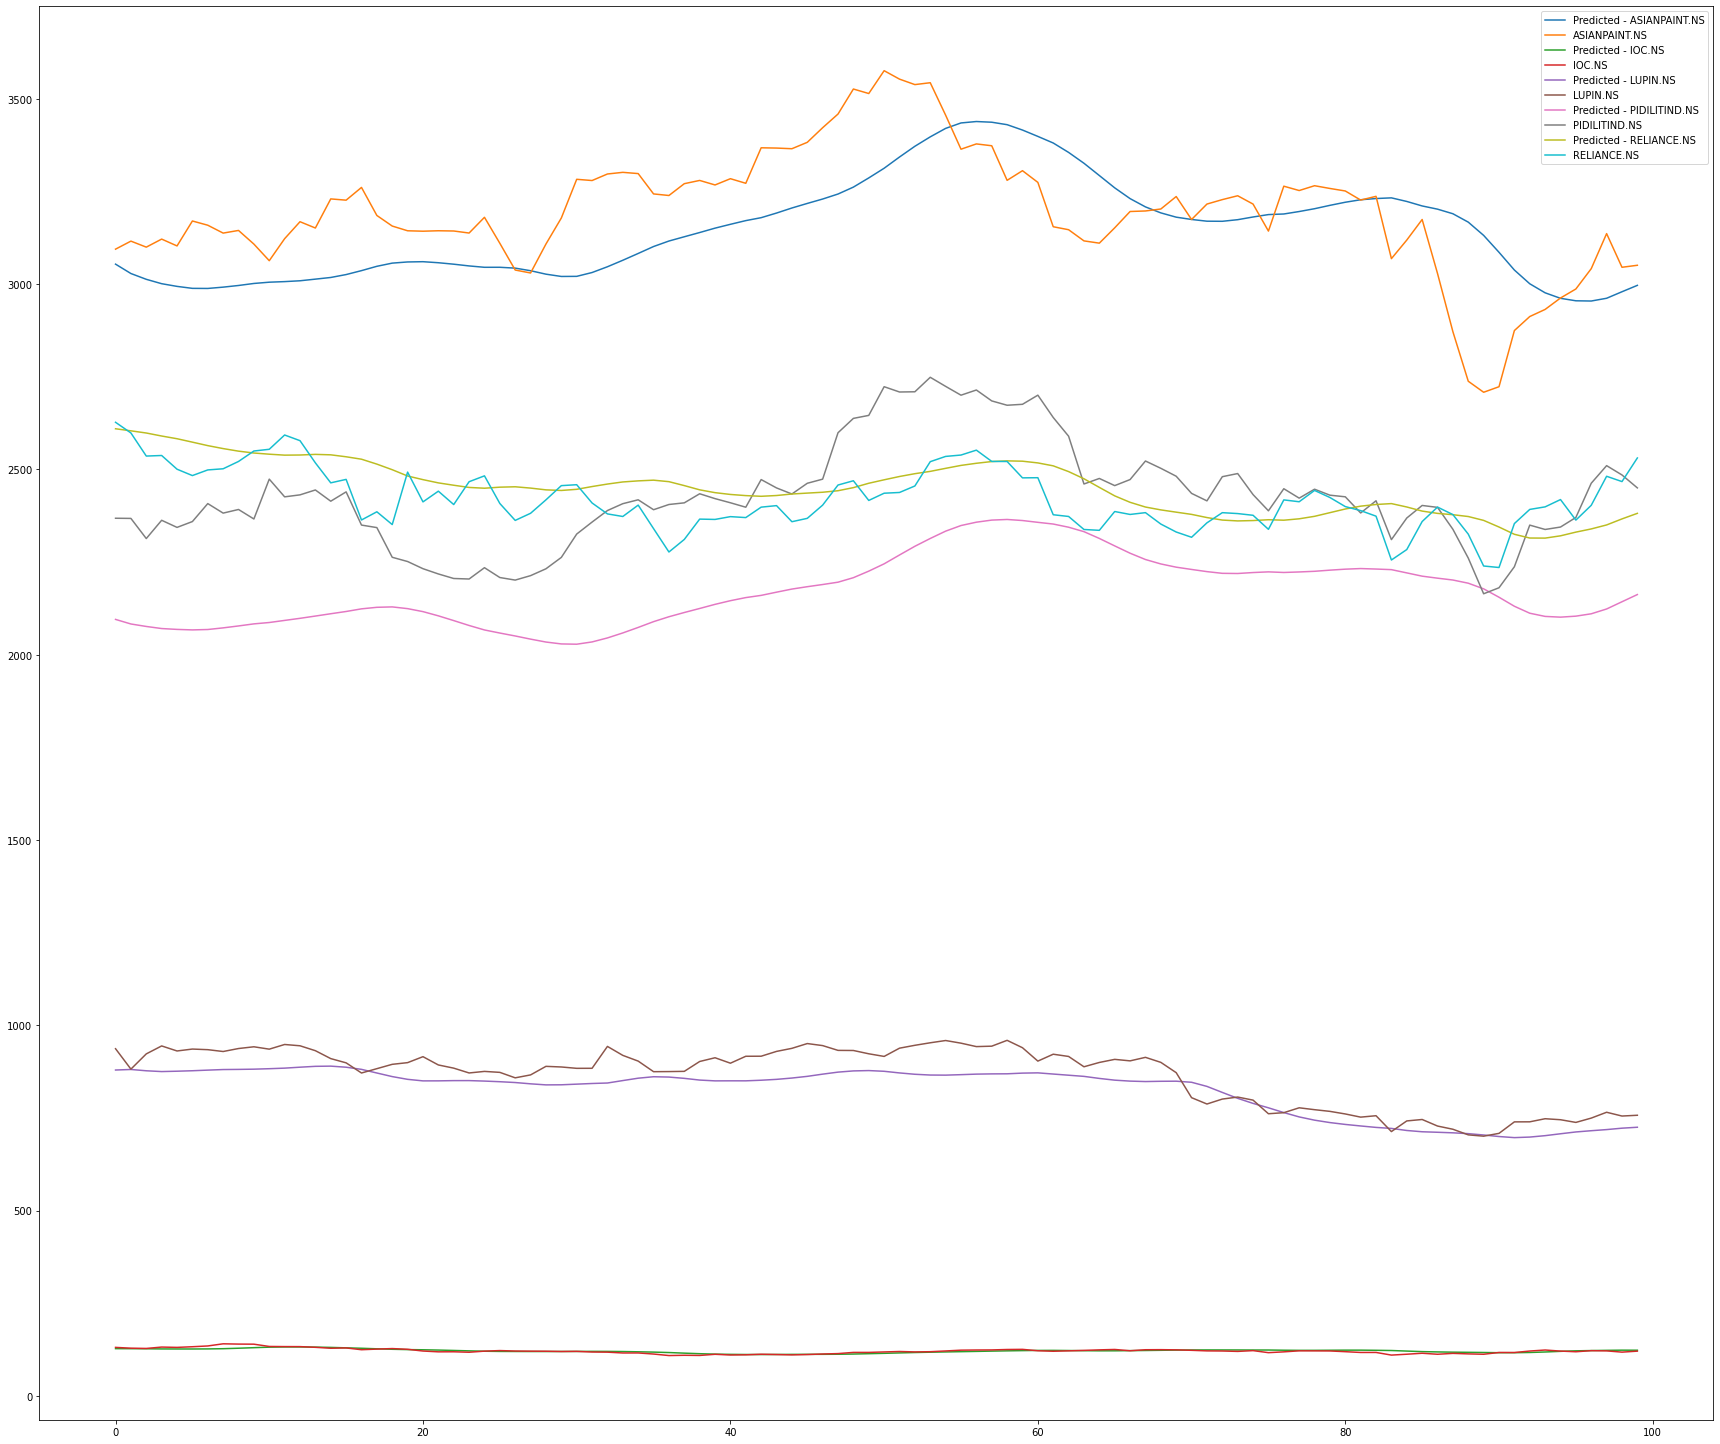

In [ ]:
score = model.evaluate(X_test_new, y_test_new)

print('Score: {}'.format(score))

yhat = model.predict(X_test_new)

# inverse transform is used to convert the scaled values back to original values

# predicted output
yhat = y_scale.inverse_transform(yhat)

# original output
y_test = y_scale.inverse_transform(y_test_new)

# Prediction plot
plt.figure(figsize = (30,26))

for i in range(len(tickers)):
  plt.plot(yhat[-100:, i], label = f'Predicted - {tickers[i]}')
  plt.plot(y_test[-100:, i], label = tickers[i])

plt.legend()
# plt.legend(handles = [pred, orig], labels = [[f'Predicted - {x}' for x in tickers], tickers])
plt.show()

## Next day stock price prediction (Portfolio)

In [ ]:
load_model = load_model("/content/drive/MyDrive/Sem 8/Sem 8 Proj/Models/GRU_port_len_5_features_1_timesteps_100.h5")
print("Model loaded!")

Model loaded!


In [ ]:
df_pred = get_data(tickers, False)

[*********************100%***********************]  5 of 5 completed


In [ ]:
df_pred = df_pred["Close"]

In [ ]:
df_pred

,ASIANPAINT.NS,IOC.NS,LUPIN.NS,PIDILITIND.NS,RELIANCE.NS
Date,,,,,
2017-03-23,1061.599976,188.399994,1490.250000,693.849976,630.671875
2017-03-24,1064.250000,186.350006,1487.800049,688.250000,637.333740
2017-03-27,1042.900024,185.449997,1457.750000,682.900024,619.676086
2017-03-28,1057.849976,184.524994,1455.699951,696.500000,617.026184
2017-03-29,1068.099976,185.074997,1454.349976,689.099976,622.425049
...,...,...,...,...,...
2022-03-16,3042.000000,121.949997,749.599976,2462.899902,2403.350098
2022-03-17,3136.600098,121.349998,765.349976,2510.399902,2481.699951
2022-03-21,3045.750000,118.000000,755.150024,2485.250000,2467.399902


In [ ]:
df_pred = df_pred.iloc[len(df_pred) - time_steps:len(df_pred), :]
df_pred = df_pred.values
df_pred

array([[3116.30004883,  128.6499939 ,  881.75      , 2368.        ,
        2598.60009766],
       [3100.10009766,  127.94999695,  922.90002441, 2313.64990234,
        2536.25      ],
       [3121.80004883,  131.6499939 ,  944.34997559, 2362.94995117,
        2537.80004883],
       [3103.35009766,  130.80000305,  930.75      , 2343.75      ,
        2500.80004883],
       [3170.64990234,  132.55000305,  935.90002441, 2359.5       ,
        2483.60009766],
       [3159.25      ,  134.6499939 ,  934.25      , 2408.        ,
        2498.85009766],
       [3138.        ,  140.44999695,  929.29998779, 2382.30004883,
        2501.94995117],
       [3145.14990234,  139.69999695,  937.34997559, 2392.10009766,
        2521.69995117],
       [3108.30004883,  139.44999695,  942.04998779, 2366.44995117,
        2549.89990234],
       [3063.5       ,  133.30000305,  935.65002441, 2474.        ,
        2554.55004883],
       [3122.89990234,  132.94999695,  948.25      , 2426.19995117,
        2593

In [ ]:
x_pred = x_scale.transform(df_pred)

print(x_pred.shape)

(100, 5)


In [ ]:
next_day_price = load_model.predict(x_pred.reshape(-1, x_pred.shape[0], x_pred.shape[1]))

In [ ]:
print(y_scale.inverse_transform(next_day_price))

[[3033.3398    116.084206  749.45996  2386.426    2505.0662  ]]


# Helper function for calculating expected returns, annual volatility and Sharpe ratio of optimized portfolio

In [57]:
def get_port_stats(returns, weights, cov_matrix):
  # EXPECTED ANNUAL RETURN
  annual_returns = returns.mean() * 252
  # find expected portfolio returns
  expected_return = np.sum(weights.T.values * annual_returns.values)

  # ANNUAL VOLATILITY
  # find annual volatility of portfolio
  volatility = np.sqrt(np.dot(weights.T,np.dot(cov_matrix * 252,weights)))

  # SHARPE RATIO (Assuming 0 risk free return. Alternative is to use a value of 0.02)
  sharpe_ratio = expected_return / volatility

  print(f"Expected Returns: {(expected_return * 100).round(decimals = 2)}%")
  print(f"Annual Volatility: {(volatility * 100).round(decimals = 2)[0][0]}%")
  print(f"Sharpe Ratio: {sharpe_ratio.round(decimals = 2)[0][0]}")

  return (expected_return * 100).round(decimals = 2), (volatility * 100).round(decimals = 2)[0][0], sharpe_ratio.round(decimals = 2)[0][0]

# Deep Learning Model for Portfolio Optimization [Method 1]

In [ ]:
sharpe_loss_data = tf.cast(tf.constant(df.iloc[1:]), float)

In [ ]:
def sharpe_loss(_, y_pred):
  # make all time-series start at 1
  data = tf.divide(sharpe_loss_data, sharpe_loss_data[0])  
            
  # value of the portfolio after allocations applied
  portfolio_values = tf.reduce_sum(tf.multiply(data, y_pred), axis=1) 
  
  portfolio_returns = (portfolio_values[1:] - portfolio_values[:-1]) / portfolio_values[:-1]  # % change formula

  sharpe = K.mean(portfolio_returns) / K.std(portfolio_returns)

  # since we want to maximize Sharpe, while gradient descent minimizes the loss, 
  # we can negate Sharpe (the min of a negated function is its max)
  return -sharpe

In [ ]:
# Historical data with returns
df_w_ret = np.concatenate([ df.values[1:], df.pct_change().values[1:] ], axis=1)

df_w_ret[0,:]

array([ 1.06425000e+03,  1.86350006e+02,  1.48780005e+03,  6.88250000e+02,
        6.37333740e+02,  2.49625516e-03, -1.08810396e-02, -1.64398669e-03,
       -8.07087380e-03,  1.05631240e-02])

In [ ]:
opt_model = Sequential([
            LSTM(64, input_shape=df_w_ret.shape),
            Flatten(),
            Dense(port_len, activation='softmax')
        ])

In [ ]:
opt_model.compile(loss=sharpe_loss, optimizer='adam')

In [ ]:
opt_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 64)                19200     
                                                                 
 flatten_9 (Flatten)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 5)                 325       
                                                                 
Total params: 19,525
Trainable params: 19,525
Non-trainable params: 0
_________________________________________________________________


In [ ]:
fit_predict_data = df_w_ret[np.newaxis,:]
fit_predict_data.shape

(1, 1235, 10)

In [ ]:
with tf.device('/device:GPU:0'):
  opt_model.fit(fit_predict_data, np.zeros((1, port_len)), epochs=20, shuffle=False)

Epoch 1/30
1/1 [==============================] - 26s 26s/step - loss: -0.0355
Epoch 2/30
1/1 [==============================] - 23s 23s/step - loss: -0.0367
Epoch 3/30
1/1 [==============================] - 27s 27s/step - loss: -0.0374
Epoch 4/30
1/1 [==============================] - 9s 9s/step - loss: -0.0381
Epoch 5/30
1/1 [==============================] - 8s 8s/step - loss: -0.0388
Epoch 6/30
1/1 [==============================] - 8s 8s/step - loss: -0.0394
Epoch 7/30
1/1 [==============================] - 8s 8s/step - loss: -0.0401
Epoch 8/30
1/1 [==============================] - 9s 9s/step - loss: -0.0408
Epoch 9/30
1/1 [==============================] - 8s 8s/step - loss: -0.0415
Epoch 10/30
1/1 [==============================] - 8s 8s/step - loss: -0.0422
Epoch 11/30
1/1 [==============================] - 8s 8s/step - loss: -0.0429
Epoch 12/30
1/1 [==============================] - 9s 9s/step - loss: -0.0435
Epoch 13/30
1/1 [==============================] - 9s 9s/step - los

In [ ]:
pred_weights_1 = opt_model.predict(fit_predict_data).T
pred_weights_1 = pd.DataFrame(pred_weights_1)
pred_weights_1

,0
0,0.113205
1,0.193688
2,0.252592
3,0.371681
4,0.068834


# Deep learning Model for Portfolio Optimization [Method 2] (Better Method)

In [124]:
pct_change = df.pct_change().dropna()
cov = np.cov(pct_change.values.T)

In [126]:
def sharpe_loss_2(_, y_pred):

  y_pred = tf.cast(y_pred, dtype = tf.float64)
  cov_tensor = tf.convert_to_tensor(cov, dtype=tf.float64)
  pct_change_tensor = tf.convert_to_tensor(pct_change, dtype=tf.float64)

  # EXPECTED ANNUAL RETURN
  annual_returns = K.mean(pct_change_tensor) * 252
  # find expected portfolio returns
  expected_return = tf.reduce_sum(tf.transpose(y_pred) * annual_returns)

  # ANNUAL VOLATILITY
  # find annual volatility of portfolio
  volatility = tf.sqrt(tf.matmul(y_pred,tf.matmul(cov_tensor*252,tf.transpose(y_pred))))

  # SHARPE RATIO (Assuming 0 risk free return)
  sharpe_ratio = expected_return / volatility

  if sharpe_ratio > 0:
    return -sharpe_ratio
  else:
    return sharpe_ratio

In [134]:
def gen_model(input_shape, outputs):
  model = Sequential([
              GRU(128, input_shape=input_shape, return_sequences = True),
              GRU(64),
              Flatten(),
              Dense(outputs, activation='softmax')
          ])

  # FOR TESTING:
  # model.compile(loss=sharpe_loss_2, optimizer='adam', run_eagerly=True)
  
  # FOR PRODUCTION:
  model.compile(loss=sharpe_loss_2, optimizer='adam')

  return model

In [128]:
# Historical data with returns
df_w_ret = np.concatenate([ df.values[1:], df.pct_change().values[1:] ], axis=1)

In [129]:
df_w_ret[0]

array([ 3.19299988e+02,  1.04290002e+03,  4.87149994e+02,  3.10987000e+02,
        5.92099976e+02,  2.91500000e+02,  1.21449997e+02,  2.63194995e+03,
        5.51750000e+02,  2.48318176e+02,  5.14424988e+02,  1.45775000e+03,
       -1.22196820e-02, -2.00610529e-02, -4.49578457e-03, -5.28640562e-03,
       -3.11480189e-03, -2.13194762e-02, -5.32351789e-03,  1.36962481e-03,
        0.00000000e+00, -5.82347050e-03, -2.47241494e-03, -2.01976394e-02])

In [135]:
opt_model_x = df_w_ret[np.newaxis, :]

opt_model_x.shape

(1, 1235, 24)

In [136]:
opt_model_2 = gen_model(np.array([opt_model_x.shape[1], opt_model_x.shape[2]]), port_len)

In [137]:
with tf.device('/device:GPU:0'):
  # Here Y [np.zeros((1, port_len))] does not matter because we don't use y_true in 
  # the custom loss function
  opt_model_2.fit(opt_model_x, np.zeros((1, port_len)), epochs=30, shuffle=False)

Epoch 1/30
1/1 [==============================] - 16s 16s/step - loss: -1.1867
Epoch 2/30
1/1 [==============================] - 11s 11s/step - loss: -1.2162
Epoch 3/30
1/1 [==============================] - 11s 11s/step - loss: -1.2433
Epoch 4/30
1/1 [==============================] - 11s 11s/step - loss: -1.2577
Epoch 5/30
1/1 [==============================] - 11s 11s/step - loss: -1.2699
Epoch 6/30
1/1 [==============================] - 11s 11s/step - loss: -1.2837
Epoch 7/30
1/1 [==============================] - 11s 11s/step - loss: -1.2920
Epoch 8/30
1/1 [==============================] - 11s 11s/step - loss: -1.2879
Epoch 9/30
1/1 [==============================] - 11s 11s/step - loss: -1.2863
Epoch 10/30
1/1 [==============================] - 11s 11s/step - loss: -1.2908
Epoch 11/30
1/1 [==============================] - 11s 11s/step - loss: -1.2937
Epoch 12/30
1/1 [==============================] - 11s 11s/step - loss: -1.2939
Epoch 13/30
1/1 [==============================] 

In [138]:
pred_weights_2 = opt_model_2.predict(opt_model_x).T
pred_weights_2 = pd.DataFrame(pred_weights_2)
pred_weights_2

,0
0,0.014290
1,0.237097
2,0.002941
3,0.074305
4,0.157514
5,0.131331
6,0.003361
7,0.106986
8,0.032326
9,0.009979


In [139]:
erDL, cvDL, srDL = get_port_stats(pct_change, pred_weights_2, cov)

Expected Returns: 17.87%
Annual Volatility: 16.78%
Sharpe Ratio: 1.07


### Portfolio Statistics of portfolio generated using method 1 [Worse method]

In [ ]:
get_port_stats(pct_change, pred_weights_1, cov)

Expected Returns: 12.99%
Annual Volatility: 19.39%
Sharpe Ratio: 0.57


# Statistical models (PyPortfolioOpt)

In [ ]:
!pip install PyPortfolioOpt

from pypfopt import HRPOpt
from pypfopt import CLA
from pypfopt import plotting
from pypfopt import risk_models
from pypfopt import expected_returns

     |████████████████████████████████| 61 kB 3.4 MB/s 
     |████████████████████████████████| 2.8 MB 10.7 MB/s 
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-1.0.31:
      Successfully uninstalled cvxpy-1.0.31


In [ ]:
df

Close                                                    
           ASIANPAINT.NS      IOC.NS     LUPIN.NS PIDILITIND.NS  RELIANCE.NS
Date                                                                        
2017-03-17   1079.449951  187.925003  1456.550049    701.900024   644.243225
2017-03-20   1079.699951  185.475006  1464.699951    699.500000   634.386658
2017-03-21   1068.699951  186.050003  1454.400024    700.150024   625.966492
2017-03-22   1057.849976  186.375000  1468.150024    693.299988   623.935730
2017-03-23   1061.599976  188.399994  1490.250000    693.849976   630.671875
...                  ...         ...          ...           ...          ...
2022-03-11   2932.000000  123.699997   747.900024   2338.149902  2399.149902
2022-03-14   2962.800049  120.800003   745.200012   2344.699951  2418.850098
2022-03-15   2987.149902  119.000000   737.950012   2370.550049  2363.449951
2022-03-16   3042.000000  121.949997   749.599976   2462.899902  2403.350098
2022-03-17   3136.600098  121.349998   765.349976   2510.399902  2481.699951

[1237 rows x 5 columns]

In [ ]:
# pct_change() calculates the percent change values and dropna() drops the missing values
returns = df.pct_change().dropna()

returns

Close                                              
           ASIANPAINT.NS    IOC.NS  LUPIN.NS PIDILITIND.NS RELIANCE.NS
Date                                                                  
2017-03-20      0.000232 -0.013037  0.005595     -0.003419   -0.015299
2017-03-21     -0.010188  0.003100 -0.007032      0.000929   -0.013273
2017-03-22     -0.010152  0.001747  0.009454     -0.009784   -0.003244
2017-03-23      0.003545  0.010865  0.015053      0.000793    0.010796
2017-03-24      0.002496 -0.010881 -0.001644     -0.008071    0.010563
...                  ...       ...       ...           ...         ...
2022-03-11      0.006592  0.022737  0.011291     -0.005000    0.002884
2022-03-14      0.010505 -0.023444 -0.003610      0.002801    0.008211
2022-03-15      0.008219 -0.014901 -0.009729      0.011025   -0.022904
2022-03-16      0.018362  0.024790  0.015787      0.038957    0.016882
2022-03-17      0.031098 -0.004920  0.021011      0.019286    0.032600

[1236 rows x 5 columns]

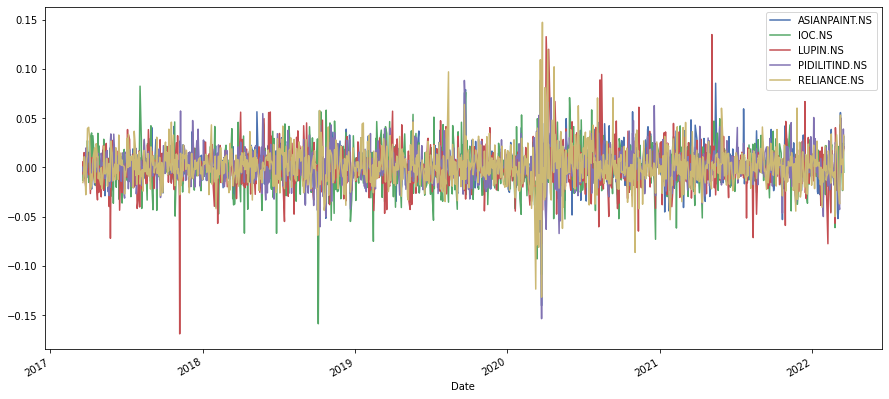

In [ ]:
returns.plot(label = tickers, figsize = (15,7))

## HRP (Hierarchical Risk Parity) [Best Model]

In [ ]:
# Using Hierarchical Risk Parity method to compute optimized portfolio weights
hrp = HRPOpt(returns)
hrp.optimize()
weights = hrp.clean_weights()
weights

OrderedDict([(('Close', 'ASIANPAINT.NS'), 0.18115),
             (('Close', 'IOC.NS'), 0.21242),
             (('Close', 'LUPIN.NS'), 0.22411),
             (('Close', 'PIDILITIND.NS'), 0.17966),
             (('Close', 'RELIANCE.NS'), 0.20266)])

In [ ]:
weightsdf = pd.DataFrame.from_dict(weights, orient="index")
weightscol = weightsdf.iloc[:, 0]
weightscol

(Close, ASIANPAINT.NS)    0.18115
(Close, IOC.NS)           0.21242
(Close, LUPIN.NS)         0.22411
(Close, PIDILITIND.NS)    0.17966
(Close, RELIANCE.NS)      0.20266
Name: 0, dtype: float64

In [ ]:
weightscol.sum()

1.0

In [ ]:
hrp.portfolio_performance(verbose=True)

Expected annual return: 13.9%
Annual volatility: 19.2%
Sharpe Ratio: 0.62


(0.13903837254267337, 0.19236659996810446, 0.6188099834504048)

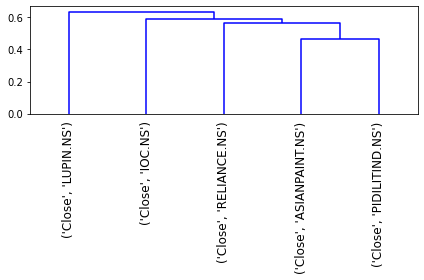

In [ ]:
plotting.plot_dendrogram(hrp) 

## CLA (Critical Line Algorithm)

In [ ]:
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

In [ ]:
mu

Close  ASIANPAINT.NS    0.242941
       IOC.NS          -0.085311
       LUPIN.NS        -0.122955
       PIDILITIND.NS    0.296710
       RELIANCE.NS      0.316481
dtype: float64

In [ ]:
S

Close                                    \
                    ASIANPAINT.NS    IOC.NS  LUPIN.NS PIDILITIND.NS   
Close ASIANPAINT.NS      0.070017  0.023275  0.009063      0.040019   
      IOC.NS             0.023275  0.107291  0.019123      0.024902   
      LUPIN.NS           0.009063  0.019123  0.101692      0.011666   
      PIDILITIND.NS      0.040019  0.024902  0.011666      0.070596   
      RELIANCE.NS        0.030536  0.031913  0.018938      0.026691   

                                 
                    RELIANCE.NS  
Close ASIANPAINT.NS    0.030536  
      IOC.NS           0.031913  
      LUPIN.NS         0.018938  
      PIDILITIND.NS    0.026691  
      RELIANCE.NS      0.098205

In [ ]:
cla = CLA(mu, S)
cla.max_sharpe()
cla.clean_weights()

OrderedDict([(('Close', 'ASIANPAINT.NS'), 0.14747),
             (('Close', 'IOC.NS'), 0.0),
             (('Close', 'LUPIN.NS'), 0.0),
             (('Close', 'PIDILITIND.NS'), 0.48722),
             (('Close', 'RELIANCE.NS'), 0.36531)])

In [ ]:
cla.portfolio_performance(verbose=True)

Expected annual return: 29.6%
Annual volatility: 22.3%
Sharpe Ratio: 1.24


(0.29600312375953075, 0.22344783664547857, 1.235201592922272)

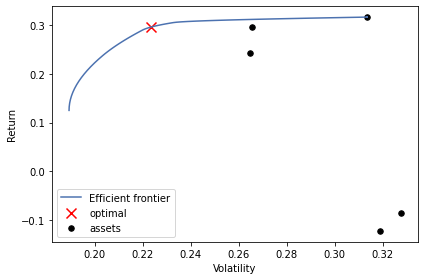

In [ ]:
plotting.plot_efficient_frontier(cla)

# Statistical Models (RiskFolio-Lib) [Best Library]

In [6]:
!pip install Riskfolio-Lib

import riskfolio as rp

In [7]:
# Calculating returns
Y = df.pct_change().dropna()
Y

,ADANIPORTS.NS,ASIANPAINT.NS,AXISBANK.NS,BHARTIARTL.NS,CIPLA.NS,COALINDIA.NS,DEEPAKNTR.NS,DRREDDY.NS,EXPLEOSOL.NS,ICICIBANK.NS,INFY.NS,LUPIN.NS
Date,,,,,,,,,,,,
2017-03-27,-0.012220,-0.020061,-0.004496,-0.005286,-0.003115,-0.021319,-0.005324,0.001370,0.000000,-0.005823,-0.002472,-0.020198
2017-03-28,0.004854,0.014335,0.032126,0.006053,0.003462,-0.003945,-0.007822,0.002204,-0.007431,0.014095,0.006123,-0.001406
2017-03-29,0.000467,0.009689,0.002784,0.012032,-0.001683,0.012915,0.011203,-0.001554,0.001552,0.018773,-0.003188,-0.000927
2017-03-30,0.057009,0.001872,-0.009818,0.018414,0.008767,-0.015641,0.011900,-0.007746,0.003099,-0.003012,-0.006154,-0.005088
2017-03-31,0.000884,0.003177,-0.016925,-0.003274,-0.009025,0.010881,0.064477,0.007309,-0.004635,-0.015994,-0.003169,-0.001209
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-17,0.022520,0.031098,0.021275,0.015309,-0.006914,-0.001978,0.002722,0.024938,-0.001647,0.017090,-0.018419,0.021011
2022-03-21,-0.006688,-0.028965,-0.018059,-0.020335,0.001717,0.032569,0.018350,-0.009203,-0.002322,-0.012984,-0.000836,-0.013327
2022-03-22,0.005441,0.001773,0.007577,0.015603,-0.016852,0.005760,-0.006322,0.006342,-0.015486,0.010482,0.018537,0.002781


/usr/local/lib/python3.7/dist-packages/riskfolio/PlotFunctions.py:2174: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(labels[permutation], rotation=90, ha="center")
/usr/local/lib/python3.7/dist-packages/riskfolio/PlotFunctions.py:2218: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


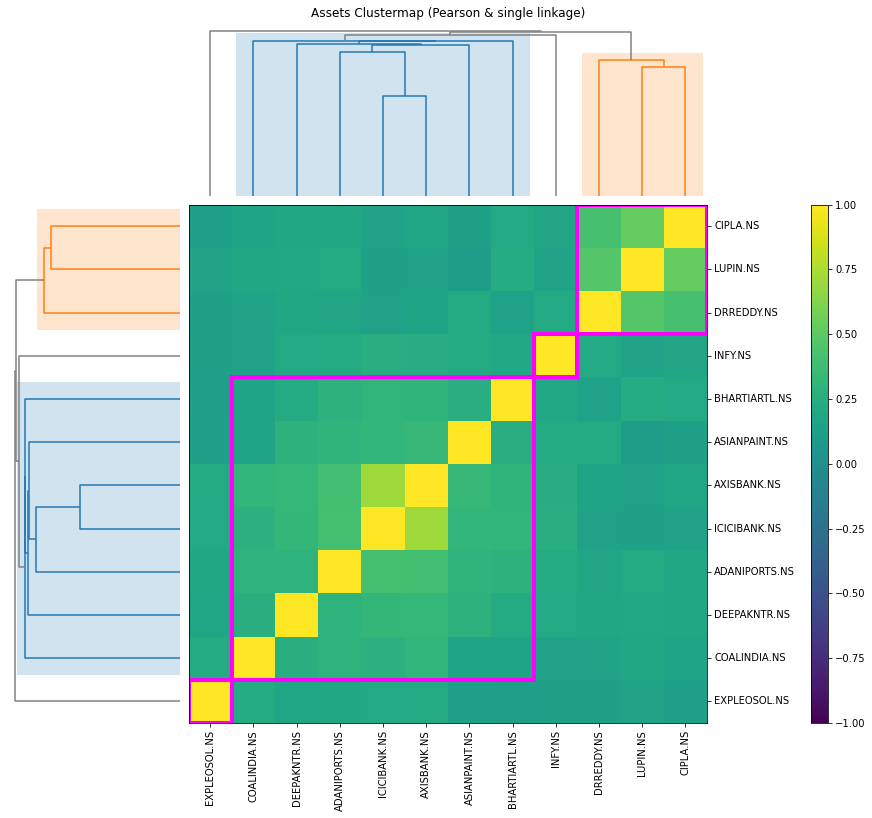

In [8]:
# Plotting Assets Clusters

ax = rp.plot_clusters(returns=Y,
                        codependence='pearson',
                        linkage='single',
                        k=None,
                        max_k=10,
                        leaf_order=True,
                        ax=None)

## HRP (Hierarchical Risk Parity)

In [38]:
# Building the portfolio object
port1 = rp.HCPortfolio(returns=Y)

In [39]:
# Estimate optimal portfolio:

model='HRP' # Could be HRP or HERC
codependence = 'pearson' # Correlation matrix used to group assets in clusters
# Risk measure
rm = 'CDaR'
rf = 0 # Risk free rate
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
linkage = 'single' # Linkage method used to build clusters
leaf_order = True # Consider optimal order of leafs in dendrogram
hist = True # Use historical scenarios for risk measures that depend on scenarios

w1 = port1.optimization(model=model,
                      codependence=codependence,
                      rm=rm,
                      rf=rf,
                      obj=obj,
                      linkage=linkage,
                      leaf_order=leaf_order,
                      hist=hist)

display(w1.T)

,ADANIPORTS.NS,ASIANPAINT.NS,AXISBANK.NS,BHARTIARTL.NS,CIPLA.NS,COALINDIA.NS,DEEPAKNTR.NS,DRREDDY.NS,EXPLEOSOL.NS,ICICIBANK.NS,INFY.NS,LUPIN.NS
weights,0.07204,0.211654,0.024188,0.064138,0.065789,0.041505,0.107336,0.141846,0.038783,0.033584,0.159548,0.039589


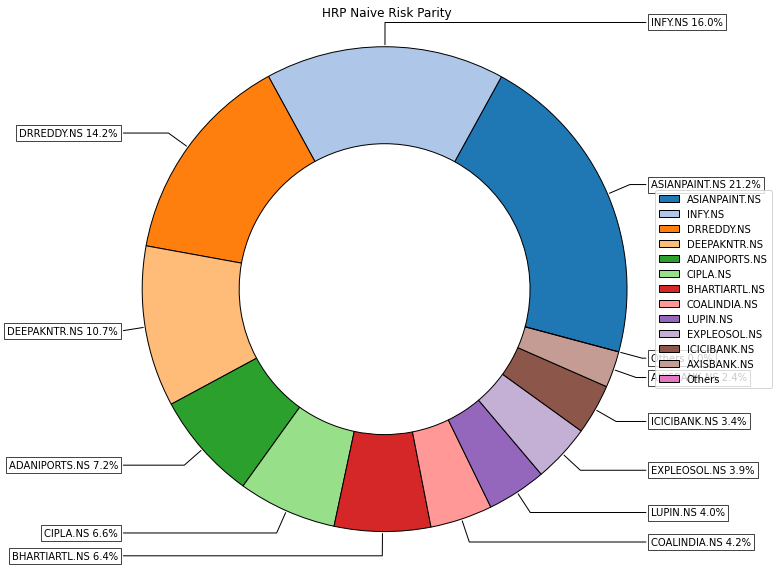

In [40]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w1,
                 title='HRP Naive Risk Parity',
                 others=0,
                 nrow=25,
                 cmap="tab20",
                 height=8,
                 width=10,
                 ax=None)

In [59]:
erW1, cvW1, srW1 = get_port_stats(port1.returns, w1, port1.cov)

Expected Returns: 25.71%
Annual Volatility: 17.97%
Sharpe Ratio: 1.43


## HERC (Hierarchical Equal Risk Contribution) [Better model than HRP] 

Reference - https://hudsonthames.org/beyond-risk-parity-the-hierarchical-equal-risk-contribution-algorithm/

In [141]:
# Building the portfolio object
port2 = rp.HCPortfolio(returns=Y)

### Using two Risk measures - CDaR and Ulcer Index

Both of these risk measures are focused towards minimizing the risk of the portfolio and assigning optimal weights to make the portfolio more robust to market volatility rather than focusing only on maximing the returns.

In [142]:
# Estimate optimal portfolio:

model='HERC' # Could be HRP or HERC
codependence = 'pearson' # Correlation matrix used to group assets in clusters
# Risk Measure - Conditional Drawdown at Risk of uncompounded cumulative returns
# rm = 'CDaR'
# Risk Measure - Ulcer Index of uncompounded cumulative returns.
rm = 'UCI'
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
rf = 0 # Risk free rate
linkage = 'ward' # Linkage method used to build clusters
max_k = 20 # Max number of clusters used in two difference gap statistic, only for HERC model
leaf_order = True # Consider optimal order of leafs in dendrogram
hist = True # Use historical scenarios for risk measures that depend on scenarios

w2 = port2.optimization(model=model,
                      codependence=codependence,
                      rm=rm,
                      rf=rf,
                      obj=obj,
                      linkage=linkage,
                      max_k=max_k,
                      leaf_order=leaf_order,
                      hist=hist)

display(w2.T)

,ADANIPORTS.NS,ASIANPAINT.NS,AXISBANK.NS,BHARTIARTL.NS,CIPLA.NS,COALINDIA.NS,DEEPAKNTR.NS,DRREDDY.NS,EXPLEOSOL.NS,ICICIBANK.NS,INFY.NS,LUPIN.NS
weights,0.011965,0.023335,0.01036,0.007651,0.312053,0.032302,0.014107,0.393592,0.038788,0.013647,0.022843,0.119356


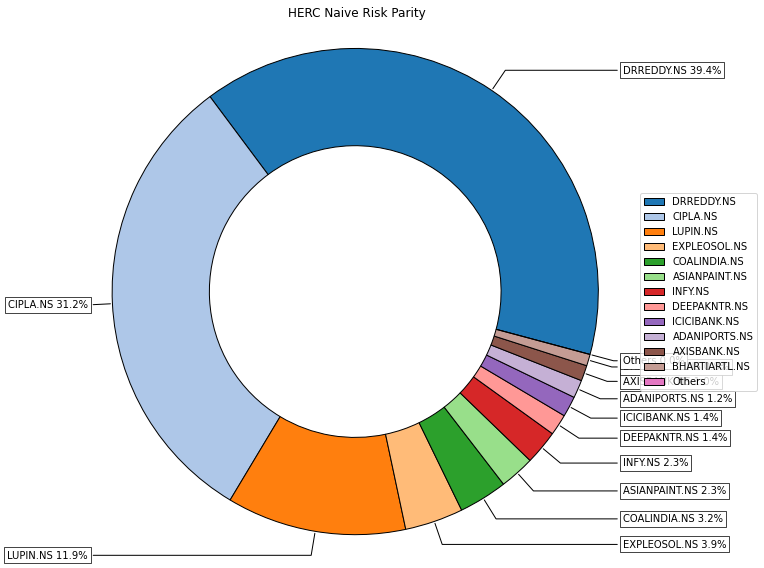

In [143]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w2,
                 title='HERC Naive Risk Parity',
                 others=0,
                 nrow=25,
                 cmap="tab20",
                 height=8,
                 width=10,
                 ax=None)

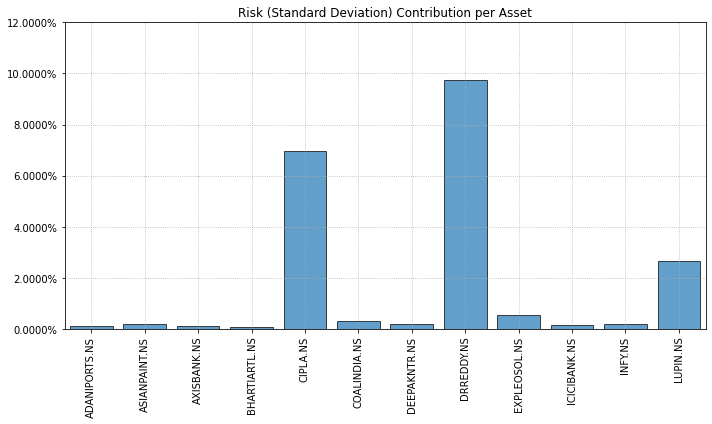

In [144]:
# Plotting the risk contribution graph of each asset

ax = rp.plot_risk_con(w=w2,
                 cov=port2.cov, 
                 returns=port2.returns, 
                 ax=None)

In [145]:
erW2, cvW2, srW2 = get_port_stats(port2.returns, w2, port2.cov)

Expected Returns: 13.76%
Annual Volatility: 21.23%
Sharpe Ratio: 0.65


# Comparsion of HRP, HERC and DL model (GRU)

In [146]:
pred_weights_index_changed = pred_weights_2.reset_index(drop = True)
pred_weights_index_changed = pred_weights_index_changed.set_index(w1.index)
pred_weights_index_changed = pred_weights_index_changed.rename({0: 'weights'}, axis=1)

In [104]:
compare_dl_w1_w2 = pd.concat([pred_weights_index_changed, w1, w2], keys=["DL Model Weights", "HRP Weights", "HERC Weights"], axis= 1)

compare_dl_w1_w2

,DL Model Weights,HRP Weights,HERC Weights
,weights,weights,weights
ADANIPORTS.NS,0.011626,0.072040,0.011965
ASIANPAINT.NS,0.237543,0.211654,0.023335
AXISBANK.NS,0.006333,0.024188,0.010360
BHARTIARTL.NS,0.072168,0.064138,0.007651
CIPLA.NS,0.157299,0.065789,0.312053
COALINDIA.NS,0.148237,0.041505,0.032302
DEEPAKNTR.NS,0.004706,0.107336,0.014107
DRREDDY.NS,0.117467,0.141846,0.393592
EXPLEOSOL.NS,0.014136,0.038783,0.038788


In [120]:
def get_stats_df(er, cv, sr, col_name):
  stats_df = pd.DataFrame(np.array([er, cv, sr]).T, index=["Expected Returns", "Annual Volatility", "Sharpe Ratio"])
  stats_df = stats_df.rename({ 0: col_name }, axis = 1)
  
  return stats_df

In [140]:
port_stats_dl_w1_w2 = pd.concat([get_stats_df(erDL, cvDL, srDL, "DL Model"),
                                 get_stats_df(erW1, cvW1, srW1, "HRP"),
                                 get_stats_df(erW2, cvW2, srW2, "HERC")], axis = 1)

port_stats_dl_w1_w2

,DL Model,HRP,HERC
Expected Returns,17.87,25.71,13.76
Annual Volatility,16.78,17.97,21.23
Sharpe Ratio,1.07,1.43,0.65
